In [1]:
import autograd.numpy as np
import numpy as pure_np
import autograd
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import pyamg

## Generate matrix with PyAMG and compute spectral radius with the default parameters

In [635]:
n = 63
num_levels = 5
grid_size = (n, n)

In [827]:
h = 1. / (n+1)
eps = 1e-4
A = pyamg.gallery.stencil_grid(np.array([[0, - eps - h, 0], 
                                         [-h - eps, 4. * eps + h * 2, - eps],
                                         [0, - eps, 0]]), 
                               grid_size, format="csr")

# A = pyamg.gallery.stencil_grid(np.array([-eps, 2*eps - h, -eps + h]), (n, ), format="csr") # Instable!
# A = pyamg.gallery.stencil_grid(np.array([-eps - h, 2*eps + h, -eps]), grid_size, format="csr")

In [828]:
if len(grid_size) == 1:
    x_range = np.linspace(0, 1, num=n+2)
    x_range = x_range[1:-1]
    x_true = np.sin(np.pi * x_range)
    rhs = (eps * np.pi**2 * x_true + np.pi * np.cos(np.pi * x_range)) / (n+1)**2
    rhs = rhs.reshape(A.shape[0], 1)
elif len(grid_size) == 2:
    x0 = np.zeros((A.shape[0], 1))
    x_range = np.linspace(0, 1, num=n+2)
    x_range = x_range[1:-1]

    x_range, y_range = np.meshgrid(x_range, x_range)
    x_true = np.sin(np.pi * x_range) * np.sin(np.pi * y_range)
    rhs = (2 * np.pi**2 * x_true * eps + np.pi * np.sin(np.pi * (x_range + y_range))) / (n+1)**2
    rhs = rhs.reshape(A.shape[0], 1)
rhs.shape

(3969, 1)

In [829]:
ml = pyamg.ruge_stuben_solver(A, CF="RS", max_levels=num_levels, 
                             presmoother=('jacobi', {'omega': 2.0/3.0, 'iterations': 2, "withrho": False}),
                             postsmoother=('jacobi', {'omega': 2.0/3.0, 'iterations' : 2, "withrho": False})
                             )


print(ml)
num_levels = len(ml.levels)

multilevel_solver
Number of Levels:     5
Operator Complexity:  3.819
Grid Complexity:      2.137
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         3969        19593 [26.18%]
    1         2196        17596 [23.51%]
    2         1254        16248 [21.71%]
    3          689        12367 [16.53%]
    4          375         9030 [12.07%]



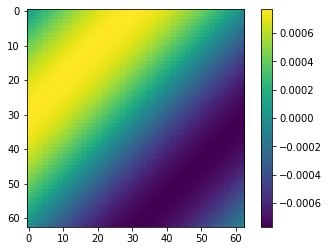

In [830]:
if len(grid_size) == 1:
    plt.plot(rhs.ravel())
elif len(grid_size) == 2:
    plt.imshow(rhs.reshape(n, n))
    plt.colorbar()

In [831]:
x = ml.solve(rhs, tol=1e-10)
x = x[:, np.newaxis]

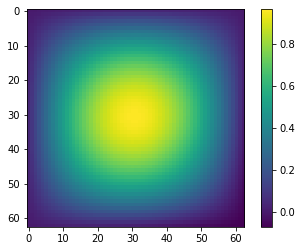

In [832]:
if len(grid_size) == 1:
    plt.plot(x)
elif len(grid_size) == 2:
    plt.imshow(x.reshape(n, n))
    plt.colorbar()

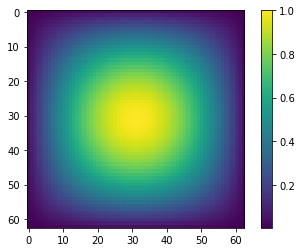

In [833]:
if len(grid_size) == 1:
    plt.plot(x_true)
elif len(grid_size) == 2:
    plt.imshow(x_true)
    plt.colorbar()

In [834]:
print("Residual norm = {}".format(np.linalg.norm(rhs-A.dot(x))))
if len(grid_size) == 2:
    print("Error = {}".format(np.linalg.norm(x_true - x.reshape(n, n))/np.linalg.norm(x_true.ravel())))
elif len(grid_size) == 1:
    print("Error = {}".format(np.linalg.norm(x_true - x.ravel()) / np.linalg.norm(x_true.ravel())))

Residual norm = 2.0579387863659945e-12
Error = 0.06393886437403573


In [835]:
for l in ml.levels[:-1]:
    print(l.R.shape, l.A.shape, l.P.shape)
    print(l.A.min(), l.A.max())
print(ml.levels[-1].A.shape, ml.levels[-1].A.min(), ml.levels[-1].A.max())

(2196, 3969) (3969, 3969) (3969, 2196)
-0.015725 0.03165
(1254, 2196) (2196, 2196) (2196, 1254)
-0.015774684044233808 0.031700315955766195
(689, 1254) (1254, 1254) (1254, 689)
-0.015774684044233808 0.031755451024228526
(375, 689) (689, 689) (689, 375)
-0.01703818758609191 0.03611176308428815
(375, 375) -0.02742891828529236 0.1257452862498226


In [836]:
def compute_spectral_radius_pyamg(pyamg_solver):
    n = pyamg_solver.levels[0].A.shape[0]
    M = spsplin.LinearOperator((n, n), 
                               matvec=lambda x: pyamg_solver.solve(np.zeros((n, 1)), x0=x, maxiter=1))
    rho = spsplin.eigs(M, k=1, return_eigenvectors=False, which="LM")[0]
    return abs(rho)

In [837]:
pyamg_rho = compute_spectral_radius_pyamg(ml)
print("Spectral radius for default parameters = {}".format(pyamg_rho))

Spectral radius for default parameters = 0.16591508784802236


## Linear interpolation hierarchy

In [838]:
def gen_linear_P(grid_size, num_levels):
    P_list = []
    n = grid_size[0]
    if len(grid_size) == 1:
        P_list.append(P)
        
    elif len(grid_size) == 2:
        k = 1
        while n > 1 and k < num_levels:
            P = np.zeros((n, (n-1) // 2))
            for i in range(P.shape[1]):
                P[2*i:2*i+3, i] = np.array([0.5, 1, 0.5])
            P_list.append(spsp.kron(spsp.csr_matrix(P), spsp.csr_matrix(P), format="csr").sorted_indices())
            n = (n-1) // 2
            k += 1
    return P_list

def gen_linear_R(grid_size, num_levels):
    R_list = []
    n = grid_size[0]
    if len(grid_size) == 1:
        P_list.append(P)
        
    elif len(grid_size) == 2:
        k = 1
        while n > 1 and k < num_levels:
            R = np.zeros(((n-1) // 2, n))
            for i in range(R.shape[0]):
                R[i, 2*i:2*i+3] = np.array([0.25, 0.5, 0.25])
            R_list.append(spsp.kron(spsp.csr_matrix(R), spsp.csr_matrix(R), format="csr").sorted_indices())
            n = (n-1) // 2
            k += 1
    return R_list

In [839]:
P_list = gen_linear_P(grid_size, num_levels)
for P_ in P_list:
    print(P_.shape)

(3969, 961)
(961, 225)
(225, 49)
(49, 9)


In [840]:
R_list = gen_linear_R(grid_size, num_levels)
for R_ in R_list:
    print(R_.shape)

(961, 3969)
(225, 961)
(49, 225)
(9, 49)


In [841]:
A_list = [A]
for i in range(len(R_list)):
    cur_A = R_list[i].dot(A_list[i]).dot(P_list[i])
    A_list.append(cur_A.tocsr().sorted_indices())
# for A in A_list:
#     print(A.shape)

## Custom implementation of V-cycle

In [842]:
import csr_compatible_primitives as csr_prim

In [843]:
def jacobi_smooth_sparse(A_values, A_indices, A_indptr, x0, b, w):
    x = x0
    n = x.shape[0]
    d = csr_prim.get_sparse_diag(A_values, A_indices, A_indptr, n)
    for i in range(2):
        Ax = csr_prim.csr_matvec(A_values, A_indptr, A_indices, x)
        x = x - w * (Ax - b) / d
    return x

In [844]:
def V_cycle(x0, b, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level=1, w=2.0/3.0):
    x = x0
    if level == 0:
        A_full = csr_prim.csr2dense(A_values[level], A_coarse_indices, A_coarse_indptr, A_coarse_indptr.shape[0] - 1)
        x = np.linalg.solve(A_full, b)
    else:
        x = jacobi_smooth_sparse(A_values[level], A_indices[level], A_indptr[level], x, b, w)
        Ax = csr_prim.csr_matvec(A_values[level], A_indptr[level], A_indices[level], x)
        res = b - Ax
        proj_res = csr_prim.csr_matvec(R_values[level], R_indptr[level], R_indices[level], res)
        e = np.zeros_like(proj_res)
        u = V_cycle(e, proj_res, A_values[:-1], A_indptr[:-1], A_indices[:-1],
                    P_values[:-1], P_indptr[:-1], P_indices[:-1], 
                    R_values[:-1], R_indptr[:-1], R_indices[:-1], 
                    level-1, w)
        Pu = csr_prim.csr_matvec(P_values[level], P_indptr[level], P_indices[level], u)
        x = x + Pu
        x = jacobi_smooth_sparse(A_values[level], A_indices[level], A_indptr[level], x, b, w)
    return x

In [845]:
A_values = [A.data for A in A_list[::-1]]
A_indices = [A.indices for A in A_list[::-1]]
A_indptr = [A.indptr for A in A_list[::-1]]
A_coarse_indices = A_indices[0]
A_coarse_indptr = A_indptr[0]

In [846]:
P_values = [[]] + [P.data for P in P_list[::-1]]
P_indices = [[]] + [P.indices for P in P_list[::-1]]
P_indptr = [[]] + [P.indptr for P in P_list[::-1]]

In [847]:
R_values = [[]] + [R.data for R in R_list[::-1]]
R_indices = [[]] + [R.indices for R in R_list[::-1]]
R_indptr = [[]] + [R.indptr for R in R_list[::-1]]

In [848]:
A_indptr[-1].shape

(3970,)

In [849]:
x = np.zeros((A.shape[0], 1))
for i in range(10):
    x = V_cycle(x, rhs, A_values, A_indptr, A_indices, 
                       P_values, P_indptr, P_indices,
                       R_values, R_indptr, R_indices,
                       level=num_levels-1, w=2.0/3.0)
    print(np.linalg.norm(A.dot(x) - rhs))

142.1187036619774
6711116.291666078
523057861778.9791
4.078340503183049e+16
3.160557584923485e+21
2.4454031617207562e+26
1.8917911419296722e+31
1.4635467141555786e+36
1.1322575662205263e+41
8.759612868870926e+45


### Compare spectral radius with PyAMG

In [850]:
def csr_3mat(A_data, A_indptr, A_indices, 
               B_data, B_indptr, B_indices, 
               C_data, C_indptr, C_indices,
               m, n, k, l):
    A_csr = spsp.csr_matrix((A_data, A_indices, A_indptr), shape=(m, n))
    A_csr.sort_indices()
    B_csr = spsp.csr_matrix((B_data, B_indices, B_indptr), shape=(n, k))
    B_csr.sort_indices()
    C_csr = spsp.csr_matrix((C_data, C_indices, C_indptr), shape=(k, l))
    C_csr.sort_indices()
    D_csr = A_csr * B_csr * C_csr
#     D_csr.eliminate_zeros()
    D_csr.sort_indices()
    return D_csr.data, D_csr.indices, D_csr.indptr

In [851]:
def generate_all_A(A_csr_value, A_csr_indices, A_csr_indptr, 
                   P_values, P_indices, P_indptr, 
                   R_values, R_indices, R_indptr,
                   RAP_list_indices, RAP_list_indptr, level=1):
    
    A_values = [[] for i in range(level+1)]
    A_indices = RAP_list_indices + [A_csr_indices]
    A_indptr = RAP_list_indptr + [A_csr_indptr]
    A_values[level] = A_csr_value
#     A_indices[level] = A_csr_indices
#     A_indptr[level] = A_csr_indptr
    
    for l in range(level-1, -1, -1):
#         print("Level", l)
        n = A_indptr[l+1].shape[0] - 1
        n_coarse = R_indptr[l+1].shape[0] - 1
#         print("R info", R_values[l+1].shape)
#         print("A info", A_values[l+1].shape)
#         print("P info", P_values[l+1].shape)
        A_values[l], _, _ = csr_prim.csr_3mat(R_values[l+1], R_indptr[l+1], R_indices[l+1], 
                                     A_values[l+1], A_indptr[l+1], A_indices[l+1], 
                                     P_values[l+1], P_indptr[l+1], P_indices[l+1], 
                                     n_coarse, n, n, n_coarse)
#         print(np.linalg.norm(A_values[l] - trial_A_list[-l-1].data))
#         print(np.linalg.norm(A_values[l] - A_list[-l-1].data))
#         print("Min A element in level {} = {}".format(l, np.min(abs(A_values[l]))))
#         print(A_values[l].shape, A_indices[l].shape, trial_A_list[-l-1].indices.shape)
    return A_values, A_indices, A_indptr

def multigrid_matvec(x, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w):
    
    rhs = np.zeros((A_indptr[-1].shape[0] - 1, 1))
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    y = V_cycle(x, rhs, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w)
    return y

def compute_spectral_radius_multigrid(A, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w):
    A_values, A_indices_, A_indptr_ = generate_all_A(A.data, A.indices, A.indptr, P_values, P_indices, P_indptr, 
                   R_values, R_indices, R_indptr,
                   A_indices, A_indptr, level)
    
#     for A_ in A_indptr_:
#         print(A_.shape)
    M = spsplin.LinearOperator((A_indptr_[-1].shape[0] - 1, A_indptr_[-1].shape[0] - 1), 
                               matvec=lambda x: multigrid_matvec(x, A_values, A_indptr_, A_indices_, 
                                               P_values, P_indptr, P_indices,
                                               R_values, R_indptr, R_indices,
                                               level, w))
    rho = spsplin.eigs(M, k=1, return_eigenvectors=False, which="LM")[0]
    return abs(rho)

In [852]:
compute_spectral_radius_multigrid(A, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level=num_levels-1, w=2./3)

77364.15281378642

## Define all for optimization

In [853]:
def v_cycle_objective(R_values_active, P_values_active, w, x, num_levels):
    K = 10
    rhs = np.zeros((A.shape[0], num_trials))
    P_values = [[]] + P_values_active
    R_values = [[]] + R_values_active
    A_values, A_indices_, A_indptr_ = generate_all_A(A.data, A.indices, A.indptr, 
                                                   P_values, P_indices, P_indptr, 
                                                   R_values, R_indices, R_indptr,
                                                   A_indices, A_indptr, 
                                                   num_levels)
    for i in range(K):
        x = V_cycle(x, rhs, A_values, A_indptr_, A_indices_, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   num_levels, w)
    loss = np.linalg.norm(x, "fro")**2
    return np.log(loss)

In [854]:
R_values_active = [R.data for R in R_list[::-1]]
P_values_active = [P.data for P in P_list[::-1]]
w = 2./3
num_trials = 5
x_batch = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
v_cycle_objective(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

227.50002670668647

In [855]:
grad = autograd.grad(v_cycle_objective, 0)

In [856]:
grad(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

[array([-83.22109667, -65.76074966,  23.49666551, -59.75164428,
          7.08655879,  57.8489603 ,  38.98704216,  66.86578119,
         -7.83876482,  -6.93539185,  -6.46601003,   6.40839235,
        -17.10523465,   1.58780631,   8.76527621,   2.30984904,
         12.94532885,  -4.32414011,  -7.52574   ,  -5.37194791,
          0.74441361,  -9.6444342 ,   0.76383527,   4.61984806,
          4.7371905 ,   9.43154698,   2.9986561 , -11.08749703,
        -19.49015016,   2.30991119,  -9.81805745,   2.71948096,
         14.54146742,  10.21727978,  13.40527103,  -6.02409925,
         -7.78910294, -46.62851801,  14.89652998, -51.24062999,
          7.04253824,  40.96520481,  18.73873909,  46.37737567,
        -29.80487566,  -5.8296372 , -11.14346114,  -3.42607014,
        -14.10324379,   2.08620845,   3.57233874,  11.16130074,
         17.31363643,  -1.12359996, -10.35896579, -14.27358362,
          6.48828961,  -8.4597814 ,   1.26867778,  13.58972364,
          1.16349895,   7.04889435,   3.

In [857]:
# %timeit grad(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

### Optimization utilities

In [858]:
from autograd.misc import flatten
from autograd.wrap_util import wraps

def unflatten_optimizer(optimize):
    """Takes an optimizer that operates on flat 1D numpy arrays and returns a
    wrapped version that handles trees of nested containers (lists/tuples/dicts)
    with arrays/scalars at the leaves."""
    @wraps(optimize)
    def _optimize(grad, x0, callback=None, *args, **kwargs):
        _x0, unflatten = flatten(x0)
        _grad = lambda x, i: flatten(grad(unflatten(x), i))[0]
        if callback:
            _callback = lambda x, i, g, num_iter, *args, **kwargs: callback(unflatten(x), i, unflatten(g), num_iter, *args, **kwargs)
        else:
            _callback = None
        return unflatten(optimize(_grad, _x0, _callback, *args, **kwargs))

    return _optimize

In [859]:
@unflatten_optimizer
def adam(grad, x, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8, *args, **kwargs):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf.
    It's basically RMSprop with momentum and some correction terms."""
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
#         print(i)
#         print(x.shape)
        g = grad(x, i)
        if callback: callback(x, i, g, num_iters, *args, **kwargs)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x = x - step_size*mhat/(np.sqrt(vhat) + eps)
    return x

In [860]:
def my_test_callback(params, current_iter, gradient, num_iters):
    if current_iter == 0 or (current_iter + 1) % 100 == 0:
        print("Iteration {}".format(current_iter + 1))
#         print("Spectral radius = {}".format(compute_spectral_radius_multigrid(A, 
#                    [[]] + params[1], P_indptr, P_indices,
#                    [[]] + params[0], R_indptr, R_indices,
#                    num_levels-1, params[2])))
        u = np.random.randint(0, 2, size=(A.shape[0], num_trials))
        u = 2 * u - 1
        print("Current objective value = {}".format(v_cycle_objective(params[0], params[1], params[2], 
                                                                      u, num_levels=num_levels-1)))

In [861]:
def obj(param, n_iter):
    x = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
    return objective(param[0], param[1], param[2], x)

def v_cycle_obj(param, n_iter):
    x = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
    return v_cycle_objective(param[0], param[1], param[2], x, num_levels=num_levels-1)

grad_v_cycle_obj = autograd.grad(v_cycle_obj)
num_iters = 1000
step_size = 5e-4

In [862]:
# grad_v_cycle_obj((R_values_active, P_values_active, w), 0)

In [863]:
PRd_opt = adam(grad_v_cycle_obj, (R_values_active, P_values_active, w), my_test_callback, num_iters, step_size, 0.9, 0.999, 10**-8)

Iteration 1
Current objective value = 228.1873982373761
Iteration 100
Current objective value = 40.729952729275325
Iteration 200
Current objective value = -0.2786188728346625
Iteration 300
Current objective value = -13.69204239647356
Iteration 400
Current objective value = -17.421135619776013
Iteration 500
Current objective value = -19.550988488501773
Iteration 600
Current objective value = -21.490432948144004
Iteration 700
Current objective value = -22.472592638831443
Iteration 800
Current objective value = -23.621251813611504
Iteration 900
Current objective value = -24.279933162595377
Iteration 1000
Current objective value = -24.752432072444233


In [864]:
print("Spectral radius = {}".format(compute_spectral_radius_multigrid(A, 
                   [[]] + PRd_opt[1], P_indptr, P_indices,
                   [[]] + PRd_opt[0], R_indptr, R_indices,
                   num_levels-1, PRd_opt[2])))

Spectral radius = 0.16136958617084693


In [ ]:
# n = 15
# 4 grids
eps_range = [1e-1, 5e-2, 1e-2, 5e-3, 1e-3, 5e-4, 1e-4]
rho_lin = [0.15496, 0.19761, 8.09471, 8.91994, 19.8979, 22.18265, 24.72881]
rho_amg = [0.20369, 0.18121, 0.26691, 0.19857, 0.14527, 0.13321, 0.11149]
rho_opt = [0.03856, 0.02801, 0.01435, 0.01177, 0.01365, 0.01531, 0.01312]

In [ ]:
# n = 31
# 5 grids

rho_lin = [0.1811, 0.30053, 271.83116, 708.73456, 13047.86087, 20158.53694, 27920.22257]
rho_amg = [0.12971, 0.32292, 0.40012, 0.31733, 0.20296, 0.17021, 0.13212]
rho_opt = [0.09816, 0.07075, 0.02911, 0.03851, 0.05005, 0.05333, 0.05215]

In [ ]:
# n = 63
# 5 grids
rho_lin = [0.19201, 0.18259, 37.66671, 1007.94452, 10249.68035, 36602.74023, 77364.15281]
rho_amg = [0.15643, 0.18127, 0.24857, 0.43685, 0.24601, 0.21215, 0.16591]
rho_opt = [0.05930, -, 0.07161, 0.07574, 0.14290, 0.15431, 0.16136]
# rho_opt[0] from amg init

In [ ]:
# n = 127
# 6 grids
rho_lin = []
rho_amg = [0.23633, ]
rho_opt = [0.067002, ]